In [2]:
# 1. Connect to a MySQL Database and Query Data

import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import text
from urllib.parse import quote_plus
import getpass
import matplotlib.pyplot as plt
import seaborn as sns

bd = "nyc_airbnb"             
user = "root"                 
host = "127.0.0.1"             
port = 3306


pw_raw = getpass.getpass("MySQL password: ")
pw = quote_plus(pw_raw)

url = f"mysql+pymysql://{user}:{pw}@{host}:{port}/{bd}?charset=utf8mb4"


engine = create_engine(url, pool_pre_ping=True)

1


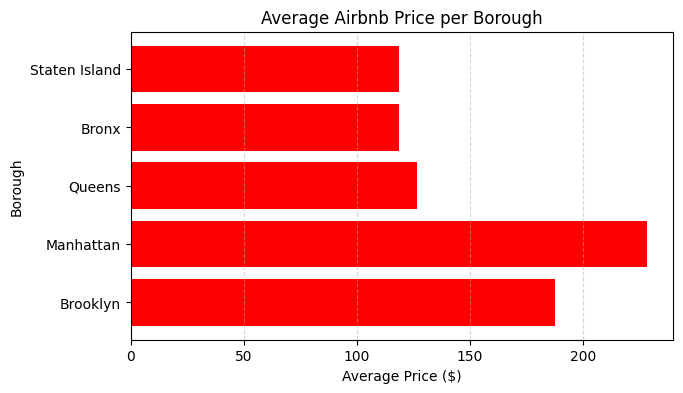

In [14]:

#================ AVG AIRBNB PRICE PER BOROUGH ================


with engine.begin() as conn:
    print(conn.exec_driver_sql("SELECT 1").scalar())

df_airbnb = pd.read_sql("""
SELECT ROUND(AVG(price),2) AS price,
       neighbourhood_group
FROM listings
GROUP BY neighbourhood_group
""", con=engine)
df_airbnb

plt.figure(figsize=(7,4))
plt.barh(df_airbnb['neighbourhood_group'], df_airbnb['price'], color='red')
plt.title('Average Airbnb Price per Borough')
plt.xlabel('Average Price ($)')
plt.ylabel('Borough')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

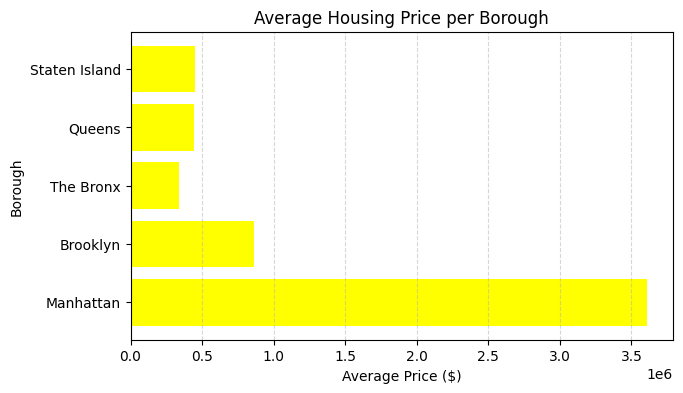

In [4]:
# =================== AVG HOUSING PRICE PER BOROUGH ===================
from sqlalchemy import text

query = text("""
SELECT AVG(price) AS avg_price, sublocality
FROM housing
WHERE sublocality IN ('The Bronx','Queens' ,'Staten Island' ,'Brooklyn' ,'Manhattan')
GROUP BY sublocality;
""")

df_housing = pd.read_sql(query, con=engine)
df_housing

plt.figure(figsize=(7,4))
plt.barh(df_housing['sublocality'], df_housing['avg_price'], color='yellow')
plt.title('Average Housing Price per Borough')
plt.xlabel('Average Price ($)')
plt.ylabel('Borough')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


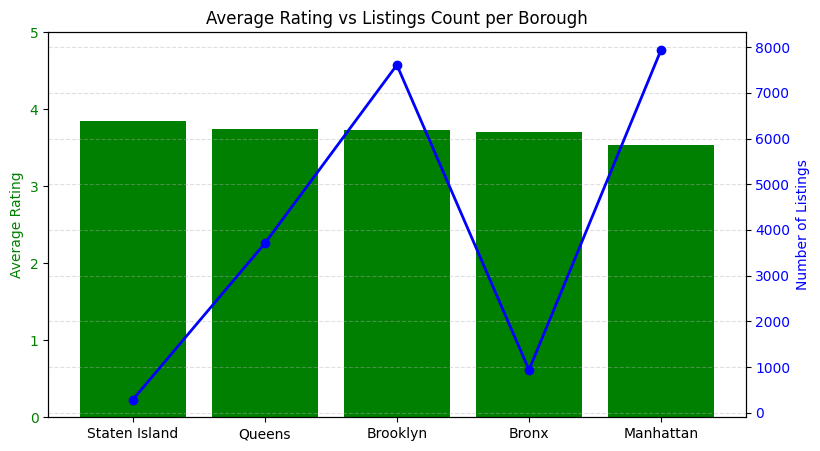

In [25]:
df_ratings = pd.read_sql("""WITH listings_rated AS (
  SELECT
    l.id,
    l.neighbourhood_group,
    CAST(REGEXP_SUBSTR(l.name, '[0-9]+(\\.[0-9]+)?') AS DECIMAL(4,2)) AS rating
  FROM listings l
)
SELECT
  neighbourhood_group,
  ROUND(AVG(rating), 2) AS avg_rating,
  COUNT(*) AS listings_count
FROM listings_rated
WHERE rating IS NOT NULL
GROUP BY neighbourhood_group
ORDER BY avg_rating DESC;""", con=engine)


fig, ax1 = plt.subplots(figsize=(9,5))

# Left axis → average rating
ax1.bar(df_ratings['neighbourhood_group'], df_ratings['avg_rating'],
        color='green', label='Avg Rating')
ax1.set_ylabel('Average Rating', color='green')
ax1.set_ylim(0, 5)
ax1.tick_params(axis='y', labelcolor='green')

# Right axis → listing count
ax2 = ax1.twinx()
ax2.plot(df_ratings['neighbourhood_group'], df_ratings['listings_count'],
         color='blue', marker='o', linewidth=2, label='Listings Count')
ax2.set_ylabel('Number of Listings', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Average Rating vs Listings Count per Borough')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()




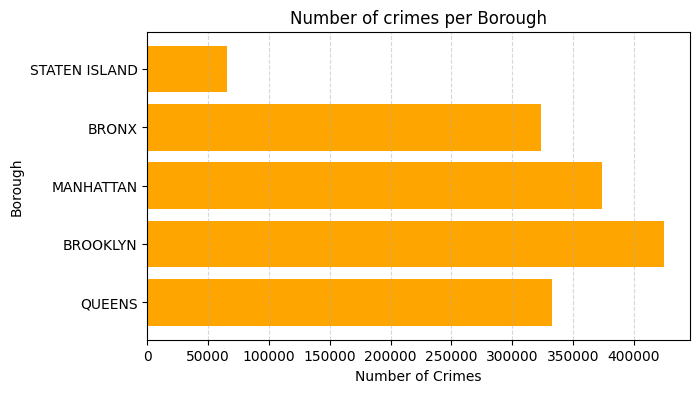

In [35]:
#================= Number of crimes PER BOROUGH ===================

df_avg_complaints = pd.read_sql("""SELECT boro_nm,
COUNT(pd_desc) AS number_complaints
FROM nypd_complaints
WHERE boro_nm IN ('BROOKLYN','QUEENS','MANHATTAN','BRONX','STATEN ISLAND')
GROUP BY boro_nm""", con=engine)
df_avg_complaints

plt.figure(figsize=(7,4))
plt.barh(df_avg_complaints['boro_nm'], df_avg_complaints['number_complaints'], color='orange')
plt.title('Number of crimes per Borough')
plt.xlabel('Number of Crimes')
plt.ylabel('Borough')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

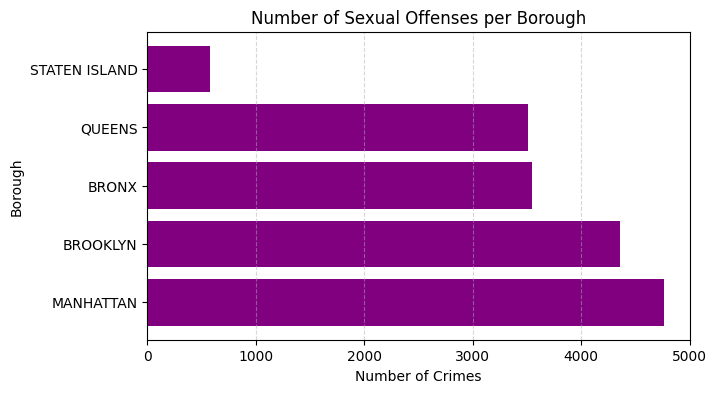

In [38]:
# ===================== SECURITY FOR WOMEN PER BOROUGH =====================

query = text("""SELECT
  c.BORO_NM,
  COUNT(*) AS total_sexual_offenses
FROM nypd_complaints AS c
WHERE c.BORO_NM IN ('BROOKLYN','QUEENS','MANHATTAN','BRONX','STATEN ISLAND')
  AND (
    c.PD_DESC LIKE '%RAPE%' OR
    c.PD_DESC LIKE '%SODOMY%' OR
    c.PD_DESC LIKE '%SEXUAL ABUSE%' OR
    c.PD_DESC LIKE '%AGGRAVATED SEXUAL%' OR
    c.PD_DESC LIKE '%SEX TRAFFICKING%' OR
    c.PD_DESC LIKE '%USE OF A CHILD IN A SEXUAL PER%' OR
    c.PD_DESC LIKE '%PROMOTING A SEXUAL PERFORMANCE%' OR
    c.PD_DESC LIKE '%STALKING COMMIT SEX OFFENSE%' OR
    c.PD_DESC LIKE '%LURING A CHILD%' OR
    c.PD_DESC LIKE '%OBSCENITY%' OR
    c.PD_DESC LIKE '%EXPOSURE OF A PERSON%' OR
    c.PD_DESC LIKE '%UNLAWFUL DISCLOSURE OF AN INTIMATE IMAGE%' OR
    c.PD_DESC LIKE '%SEX CRIMES%'
  )
GROUP BY c.BORO_NM
ORDER BY total_sexual_offenses DESC""")


df_women_security= pd.read_sql(query, con=engine)

df_women_security

plt.figure(figsize=(7,4))
plt.barh(df_women_security['BORO_NM'], df_women_security['total_sexual_offenses'], color='purple')
plt.title('Number of Sexual Offenses per Borough')
plt.xlabel('Number of Crimes')
plt.ylabel('Borough')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

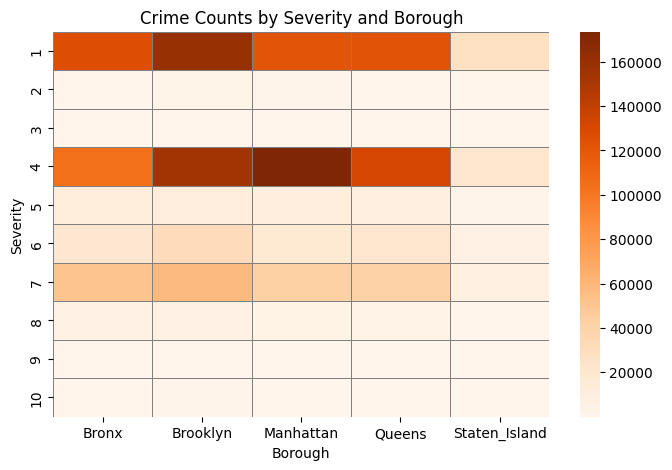

In [39]:

#================= TOTAL CRIMES BY SEVERITY AND BOROUGH ===================

from sqlalchemy import text

query = text("""
WITH scored AS (
  SELECT 
    c.BORO_NM,
    CASE
      WHEN PD_DESC LIKE '%MURDER%' THEN 10
      WHEN PD_DESC LIKE '%TERRORISM%' OR PD_DESC LIKE '%SUPP. ACT TERR%' THEN 10
      WHEN PD_DESC LIKE '%RAPE%' THEN 10
      WHEN PD_DESC LIKE '%SODOMY%' THEN 10
      WHEN PD_DESC LIKE '%KIDNAPPING 1%' THEN 10
      WHEN PD_DESC LIKE '%KIDNAPPING 2%' THEN 9
      WHEN PD_DESC LIKE '%SEX TRAFFICKING%' THEN 9
      WHEN PD_DESC LIKE '%USE OF A CHILD IN A SEXUAL PER%' THEN 9
      WHEN PD_DESC LIKE '%AGGRAVATED SEXUAL%' THEN 9
      WHEN PD_DESC LIKE '%ARSON 1%' THEN 9
      WHEN PD_DESC LIKE '%AGGRAVATED CRIMINAL CONTEMPT%' THEN 8
      WHEN PD_DESC LIKE '%ASSAULT POLICE%' OR PD_DESC LIKE '%ASSAULT OTHER PUBLIC%' THEN 8
      WHEN PD_DESC LIKE '%STRANGULATION%' THEN 8
      WHEN PD_DESC LIKE '%ASSAULT TRAFFIC%' OR PD_DESC LIKE '%ASSAULT SCHOOL SAFETY%' THEN 7
      WHEN PD_DESC LIKE '%ASSAULT%' THEN 7
      WHEN PD_DESC LIKE '%RECKLESS ENDANGERMENT%' THEN 7
      WHEN PD_DESC LIKE '%COERCION 1%' THEN 7
      WHEN PD_DESC LIKE '%RAPE 3%' THEN 7
      WHEN PD_DESC LIKE '%CRIMINAL DISPOSAL FIREARM%' THEN 7
      WHEN PD_DESC LIKE '%WEAPONS POSSESSION%' OR PD_DESC LIKE '%CRIM POS WEAP%' THEN 7
      WHEN PD_DESC LIKE '%OBSTR BREATH%' THEN 6
      WHEN PD_DESC LIKE '%CRIMINAL CONTEMPT%' THEN 6
      WHEN PD_DESC LIKE '%AGGRAVATED HARASSMENT%' THEN 6
      WHEN PD_DESC LIKE '%RESISTING ARREST%' THEN 5
      WHEN PD_DESC LIKE '%RECKLESS DRIVING%' THEN 5
      WHEN PD_DESC LIKE '%BAIL JUMPING%' THEN 5
      WHEN PD_DESC LIKE '%FALSE REPORT%' OR PD_DESC LIKE '%FALSE ALARM%' THEN 5
      WHEN PD_DESC LIKE '%MENACING%' THEN 5
      WHEN PD_DESC LIKE '%OBSCENE MATERIAL%' THEN 5
      WHEN PD_DESC LIKE '%PROMOTING A SEXUAL PERFORMANCE%' THEN 5
      WHEN PD_DESC LIKE '%VIOLATION OF ORDER%' THEN 5
      WHEN PD_DESC LIKE '%TORTURE/INJURE ANIMAL%' THEN 5
      WHEN PD_DESC LIKE '%CAUSE SPI/KILL ANIMAL%' THEN 5
      WHEN PD_DESC LIKE '%COURSE OF SEXUAL CONDUCT%' THEN 5
      WHEN PD_DESC LIKE '%CRIMINAL MIS%' THEN 4
      WHEN PD_DESC LIKE '%PETIT LARCENY%' OR PD_DESC LIKE '%LARCENY%' THEN 4
      WHEN PD_DESC LIKE '%LEAVING THE SCENE%' OR PD_DESC LIKE '%LEAVING SCENE%' THEN 4
      WHEN PD_DESC LIKE '%CRIMINAL POSSESSION WEAPON%' THEN 4
      WHEN PD_DESC LIKE '%UNAUTHORIZED USE VEHICLE%' THEN 4
      WHEN PD_DESC LIKE '%PROSTITUTION%' THEN 3
      WHEN PD_DESC LIKE '%DISORDERLY CONDUCT%' THEN 3
      WHEN PD_DESC LIKE '%CANNABIS%' OR PD_DESC LIKE '%MARIJUANA%' THEN 3
      WHEN PD_DESC LIKE '%TAX LAW%' THEN 3
      WHEN PD_DESC LIKE '%ALCOHOLIC BEVERAGE CONTROL%' THEN 3
      WHEN PD_DESC LIKE '%JOSTLING%' THEN 3
      WHEN PD_DESC LIKE '%EDUCATION LAW%' THEN 3
      WHEN PD_DESC LIKE '%BUILDING MATERIAL%' THEN 3
      WHEN PD_DESC LIKE '%GENERAL BUSINESS LAW%' THEN 3
      WHEN PD_DESC LIKE '%FIREWORKS%' THEN 2
      WHEN PD_DESC LIKE '%FIREARMS LICENSING%' THEN 2
      WHEN PD_DESC LIKE '%GRAFFITI%' THEN 2
      WHEN PD_DESC LIKE '%THEFT OF SERVICES%' THEN 2
      WHEN PD_DESC LIKE '%SALE SCHOOL GROUNDS%' THEN 2
      WHEN PD_DESC LIKE '%UNAUTH. SALE OF TRANS. SERVICE%' THEN 2
      WHEN PD_DESC LIKE '%UNLAWFUL SALE SYNTHETIC MARIJUANA%' THEN 2
      WHEN PD_DESC LIKE '%AIRPOLLUTION%' THEN 2
      WHEN PD_DESC LIKE '%HEALTHCARE%' OR PD_DESC LIKE '%RENT.REG%' THEN 2
      WHEN PD_DESC LIKE '%POSSESSION HYPODERMIC%' THEN 2
      WHEN PD_DESC LIKE '%COMPUTER%' THEN 2
      WHEN PD_DESC LIKE '%RIOT%' THEN 2
      WHEN PD_DESC LIKE '%POSTING ADVERTISEMENTS%' THEN 2
      WHEN PD_DESC LIKE '%OBSCENITY%' THEN 2
      WHEN PD_DESC LIKE '%BREED/TRAIN/HOST ANIMAL FIGHTING%' THEN 2
      WHEN PD_DESC LIKE '%EAVESDROPPING%' THEN 2
      WHEN PD_DESC LIKE '%POSSES OR CARRY A KNIFE%' THEN 2
      WHEN PD_DESC LIKE '%IMITATION PISTOL%' THEN 2
      WHEN PD_DESC LIKE '%INAPPROPIATE SHELTER DOG LEFT%' THEN 2
      WHEN PD_DESC LIKE '%ABANDON ANIMAL%' THEN 2
      WHEN PD_DESC LIKE '%CONFINING ANIMAL%' THEN 2
      WHEN PD_DESC LIKE '%NEGLECT/POISON ANIMAL%' THEN 2
      WHEN PD_DESC LIKE '%EXPOSURE OF A PERSON%' THEN 2
      WHEN PD_DESC LIKE '%MATERIAL OFFENSIV%' THEN 2
      WHEN PD_DESC LIKE '%N.Y.C. TRANSIT AUTH. R&R%' THEN 2
      WHEN PD_DESC LIKE '%SEXUAL ABUSE%' THEN 6
      WHEN PD_DESC LIKE '%OBSCENITY%' THEN 5
      WHEN PD_DESC LIKE '%MENACING 1ST%' THEN 6
      WHEN PD_DESC LIKE '%COERCION 2%' THEN 6
      WHEN PD_DESC LIKE '%STALKING%' THEN 7
      WHEN PD_DESC LIKE '%PROMOTING SUICIDE%' THEN 7
      WHEN PD_DESC LIKE '%CRIM USE BIO OR CHEM WEAPON%' THEN 10
      WHEN PD_DESC LIKE '%ENTERPRISE CORRUPTION%' THEN 8
      WHEN PD_DESC LIKE '%MONEY LAUNDERING%' THEN 5
      WHEN PD_DESC LIKE '%FORTUNE TELLING%' THEN 1
      WHEN PD_DESC LIKE '%GYPSY CAB%' THEN 1
      WHEN PD_DESC LIKE '%ABSCONDING FROM WORK RELEASE%' THEN 3
      ELSE 1
    END AS severity
  FROM nypd_complaints c
  WHERE c.BORO_NM IN ('BROOKLYN','QUEENS','MANHATTAN','BRONX','STATEN ISLAND')
)
SELECT
  severity,
  SUM(CASE WHEN BORO_NM='BROOKLYN'      THEN 1 ELSE 0 END) AS Brooklyn,
  SUM(CASE WHEN BORO_NM='MANHATTAN'     THEN 1 ELSE 0 END) AS Manhattan,
  SUM(CASE WHEN BORO_NM='QUEENS'        THEN 1 ELSE 0 END) AS Queens,
  SUM(CASE WHEN BORO_NM='BRONX'         THEN 1 ELSE 0 END) AS Bronx,
  SUM(CASE WHEN BORO_NM='STATEN ISLAND' THEN 1 ELSE 0 END) AS Staten_Island,
  COUNT(*) AS Total
FROM scored
GROUP BY severity
ORDER BY severity DESC;
""")


df_total_crimes = pd.read_sql(query, con=engine)
df_total_crimes


#================= HEATMAP OF CRIME SEVERITY BY BOROUGH ===================

#First, we need to reshape the DataFrame to long format for seaborn heatmap

df_long = df_total_crimes.melt(
    id_vars='severity',
    value_vars=['Brooklyn','Manhattan','Queens','Bronx','Staten_Island'],
    var_name='Borough',
    value_name='Crimes'
)

plt.figure(figsize=(8,5))
heat = sns.heatmap(
    df_long.pivot(index='severity', columns='Borough', values='Crimes'),
    cmap='Oranges',
    linewidths=.5,
    linecolor='gray'
)
plt.title('Crime Counts by Severity and Borough')
plt.xlabel('Borough')
plt.ylabel('Severity')
plt.show()








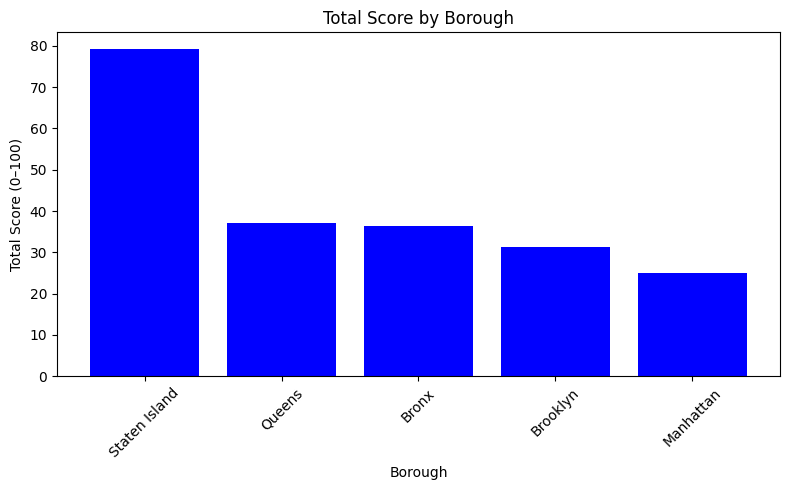

In [5]:
df_total_score= pd.read_sql("""SELECT
  borough,                                           
  total_score_100                                    
FROM v_borough_scores_ranked
ORDER BY total_score_100 DESC""", con=engine)
df_total_score


plt.figure(figsize=(8,5))
plt.bar(df_total_score['borough'], df_total_score['total_score_100'], color='blue')
plt.title('Total Score by Borough')
plt.xlabel('Borough')
plt.ylabel('Total Score (0–100)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()